# Natural Language Entity Extraction
Extracting Ground Truth Labels from Radiology Reports
<hr/>



- Extracting disease labels from clinical reports
    - Text matching
    - Evaluating a labeler
    - Negation detection
    - Dependency parsing
    - Preprocessing text for input
    - Extracting answers from model output 

Look for referenfe [here](https://arxiv.org/abs/1901.07031) 




<a name="0"></a>
## Packages

In [ ]:
import matplotlib.pyplot as plt
import nltk 
import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import *

from public_tests import *

In [ ]:
from util import *

<a name="1"></a>
## 1. Extracting Labels



The test set consists of 1,000 X-ray reports that have been manually labeled by a board certified radiologist for the presence or lack of presence of different pathologies. 
- We also have access to the extracted "Impression" section of each report which is the overall summary of the radiologists for each X-ray. 

Have a look at the dataset:

In [ ]:
print("test_df size: {}".format(test_df.shape))
test_df.head()

test_df size: (1000, 12)


,Report Impression,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
0,"\n \n1.mild pulmonary edema, and cardiomegaly....",True,False,False,True,False,False,True,False,True,False,False
1,\n \n1.unremarkable cardiomediastinal silhouet...,False,False,True,False,False,False,False,False,False,False,True
2,\n1. lines and tubes are unchanged in position...,False,False,True,False,False,False,False,False,False,False,False
3,\n1. postoperative portable film with a right-...,False,False,True,True,False,False,True,True,False,False,False
4,\n \n1.single frontal view of the chest demons...,False,False,True,False,False,False,False,False,True,False,False


In [ ]:
#examples
for i in range(3):
    print(f'\nReport Impression {i}:')
    print(test_df.loc[i, 'Report Impression'])


Report Impression 0:

 
1.mild pulmonary edema, and cardiomegaly.  trace pleural fluid 
effusions.
 
2.low lung volumes with minimal basilar atelectasis.
 
3.no new focal consolidation. 
 
4.interval placement of defibrillation pads.  
 


Report Impression 1:

 
1.unremarkable cardiomediastinal silhouette
 
2.diffuse reticular pattern, which can be seen with an atypical 
infection or chronic fibrotic change.  no focal consolidation.
 
3.no pleural effusion or pneumothorax
 
4.mild degenerative changes in the lumbar spine and old right rib 
fractures. 
 


Report Impression 2:

1. lines and tubes are unchanged in position.
2. increasing retrocardiac opacity and left midlung zone opacity.
3. there is a deep left costophrenic sulcus which is increased when
compared with prior films. no definite evidence of left
pneumothorax. clinical correlation is recommended. if clinically
indicated, consider film in expiration or decubitus views.
4. the icu team was informed of these results at 10 am

These reports are fairly unstructured, which makes information extraction challenging. 

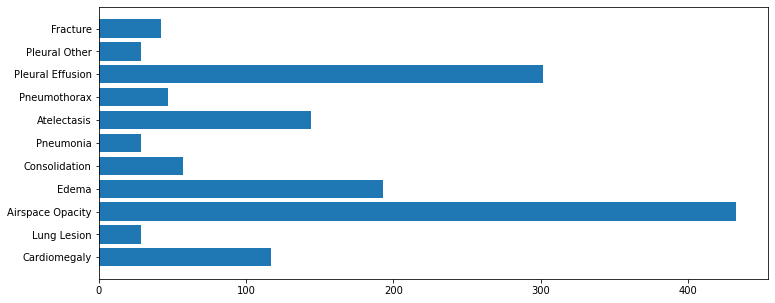

In [ ]:
#Data distribution
plt.figure(figsize=(12,5))
plt.barh(y=CATEGORIES, width=test_df[CATEGORIES].sum(axis=0))
plt.show()

Pathologies like Airspace Opacity, Pleural Effusion, and Edema are present in many of the reports while Lung Lesion and Pneumonia are not as common in this dataset.

<a name="1-1"></a>
### 1.1 Text Matching
:

In [ ]:
cat = CATEGORIES[2]
related_keywords = get_mention_keywords(cat)
print("Related keywords for {} are:\n{}".format(cat, ', '.join(related_keywords)))

Related keywords for Airspace Opacity are:
opaci, decreased translucency, increased density, airspace disease, air-space disease, air space disease, infiltrate, infiltration, interstitial marking, interstitial pattern, interstitial lung, reticular pattern, reticular marking, reticulation, parenchymal scarring, peribronchial thickening, wall thickening, scar


In [ ]:
def get_labels(sentence_l):
    """
    Returns a dictionary that indicates presence of each category (from CATEGORIES) 
    in the given sentences.
    
    
    Args: 
        sentence_l (array of strings): array of strings representing impression section
    Returns:
        observation_d (dict): dictionary mapping observation from CATEGORIES array to boolean value
    """
    observation_d = {}
    
    # loop through each category
    for cat in CATEGORIES:
        
        # Initialize the observations for all categories to be False
        observation_d[cat] = False

    # For each sentence in the list:
    for s in sentence_l: 
        
        # Set the characters to all lowercase, for consistent string matching
        s = s.lower()
        
        # for each category
        for cat in CATEGORIES: 
            
            # for each phrase that is related to the keyword (use the given function)
            for phrase in get_mention_keywords(cat): 
            
                # make the phrase all lowercase for consistent string matching
                phrase = phrase.lower()
                
                # check if the phrase appears in the sentence
                if phrase in s: 
                    observation_d[cat] = True

    
   
    return observation_d

<a name="1-2"></a>
### 1.2 Evaluating The Performance


$$F_1 = \left( \frac{2}{ \frac{1}{recall} + \frac{1}{precision} }\right) = 2 \times \frac{precision \times recall}{precision + recall}$$

In [ ]:
get_f1_table(get_labels, test_df)

,Label,F1
0,Cardiomegaly,0.718
1,Lung Lesion,0.641
2,Airspace Opacity,0.923
3,Edema,0.708
4,Consolidation,0.270
5,Pneumonia,0.369
6,Atelectasis,0.646
7,Pneumothorax,0.218
8,Pleural Effusion,0.722
9,Pleural Other,0.667


Airspace Opacity has the highest F1 score at 0.923 while Pneumothorax has the lowest at 0.218. 

These numbers are actually not too bad given the simplicity of this rules-based implemention, but we can do a lot better.

<a name="1-3"></a>
### 1.3 Cleanup



In [ ]:
raw_text = test_df.loc[28, 'Report Impression']
print("raw text: \n\n" + raw_text)
print("cleaned text: \n\n" + clean(raw_text))

raw text: 


 
1.  bibasilar opacities, without significant change from the prior 
study, likely representing bilateral pleural effusions with 
atelectasis and/or pneumonia.
 
2.  interval decrease in focal opacification within the right upper 
lung.
 
3.  lines and tubes are unchanged. the distal tip of enteric tube 
remains coiled within the stomach.
 
 

cleaned text: 

1. bibasilar opacities, without significant change from the prior study, likely representing bilateral pleural effusions with atelectasis or pneumonia. 2. interval decrease in focal opacification within the right upper lung. 3. lines and tubes are unchanged. the distal tip of enteric tube remains coiled within the stomach.


In [ ]:
get_f1_table(get_labels, test_df, cleanup=True)

,Label,F1
0,Cardiomegaly,0.725
1,Lung Lesion,0.641
2,Airspace Opacity,0.922
3,Edema,0.707
4,Consolidation,0.270
5,Pneumonia,0.369
6,Atelectasis,0.646
7,Pneumothorax,0.218
8,Pleural Effusion,0.722
9,Pleural Other,0.687


<a name="1-4"></a>
### 1.4 Finding Negative Mentions

<a name='ex-02'></a>


In [ ]:
def get_labels_negative_aware(sentence_l):
    """
    Returns a dictionary that indicates presence of categories in
    sentences within the impression section of the report.
    Only set a label to True if no 'negative words' appeared in the sentence.
    
    Args: 
        sentence_l (array of strings): array of strings representing impression section
    Returns:
        observation_d (dict): dictionary mapping observation from CATEGORIES array to boolean value
    """
    # Notice that all of the negative words are written in lowercase
    negative_word_l = ["no", "not", "doesn't", "does not", "have not", "can not", "can't", "n't"]
    observation_d = {}
    
  
    
    # Initialize the observation dictionary 
    # so that all categories are not marked present.
    for cat in CATEGORIES: 
        
        # Initialize category to not present.
        observation_d[cat] = False

    # Loop through each sentence in the list of sentences
    for s in sentence_l: 
        
        # make the sentence all lowercase
        s = s.lower()
        
        # Initialize the flag to indicate no negative mentions (yet)
        negative_flag = False
        
        # Go through all the negative words in the list
        for neg in negative_word_l:
            
            # Check if the word is a substring in the sentence
            if neg in s: 
                # set the flag to indicate a negative mention
                negative_flag = True
                

        # When a negative word was not found in the sentence,
        # check for the presence of the diseases
        if not negative_flag: 
            
            # Loop through the categories list
            for cat in CATEGORIES:
                
                # Loop through each phrase that indicates this category
                for phrase in get_mention_keywords(cat): 

                        # make the phrase all lowercase
                        phrase = phrase.lower()
                        
                        # Check if the phrase is a substring in the sentence
                        if phrase in s:
                            
                            # Set the observation dictionary
                            # to indicate the presence of this category
                            observation_d[cat] = True



    
    return observation_d

Check how this changes your aggregate performance:

In [ ]:
get_f1_table(get_labels_negative_aware, test_df, cleanup=True)

,Label,F1
0,Cardiomegaly,0.807
1,Lung Lesion,0.465
2,Airspace Opacity,0.905
3,Edema,0.795
4,Consolidation,0.424
5,Pneumonia,0.463
6,Atelectasis,0.642
7,Pneumothorax,0.656
8,Pleural Effusion,0.859
9,Pleural Other,0.621


You should see a generally significant boost in the F1 score across the board. 
- With the `get_labels()` method, Pneumothorax has an F1 score of 0.218.
- With the `get_labels_negative_aware()` method, Pneumothorax has an F1 score of 0.656.

In [ ]:
sampled_test = test_df.sample(200,random_state=0)

In [ ]:
negbio_preds = get_negbio_preds(sampled_test)

/opt/conda/lib/python3.6/site-packages/jpype/_core.py:217: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)
  0%|          | 0/200 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/StanfordDependencies/JPypeBackend.py:160: UserWarning: This jar doesn't support universal dependencies, falling back to Stanford Dependencies. To suppress this message, call with universal=False
  warnings.warn("This jar doesn't support universal "
/opt/conda/lib/python3.6/site-packages/StanfordDependencies/JPypeBackend.p

In [ ]:
calculate_f1(sampled_test, negbio_preds)

,Label,F1
0,Cardiomegaly,0.877
1,Lung Lesion,0.889
2,Airspace Opacity,0.952
3,Edema,0.808
4,Consolidation,0.370
5,Pneumonia,0.467
6,Atelectasis,0.725
7,Pneumothorax,0.326
8,Pleural Effusion,0.875
9,Pleural Other,0.588


In [ ]:
basic = get_f1_table(get_labels, sampled_test).rename(columns={"F1": "F1 Basic"})
clean_basic = get_f1_table(get_labels, sampled_test, cleanup=True).rename(columns={"F1": "F1 Cleaned"})
negated_basic = get_f1_table(get_labels_negative_aware, sampled_test, cleanup=True).rename(columns={"F1": "F1 Negative Basic"})
negated_negbio = calculate_f1(sampled_test, negbio_preds).rename(columns={"F1": "F1 Negbio"})

joined_preds = basic.merge(clean_basic, on="Label")
joined_preds = joined_preds.merge(negated_basic, on="Label")
joined_preds = joined_preds.merge(negated_negbio,  on="Label")

joined_preds

,Label,F1 Basic,F1 Cleaned,F1 Negative Basic,F1 Negbio
0,Cardiomegaly,0.758,0.771,0.815,0.877
1,Lung Lesion,0.762,0.762,0.333,0.889
2,Airspace Opacity,0.948,0.948,0.922,0.952
3,Edema,0.759,0.759,0.771,0.808
4,Consolidation,0.260,0.260,0.409,0.370
5,Pneumonia,0.359,0.359,0.467,0.467
6,Atelectasis,0.605,0.605,0.579,0.725
7,Pneumothorax,0.167,0.167,0.600,0.326
8,Pleural Effusion,0.730,0.730,0.839,0.875
9,Pleural Other,0.588,0.556,0.533,0.588


What if you want to support any question a physician might want to ask? To do this, you'll have to use more recent artificial intelligence techniques and large datasets. 
- Usin pre- and post-processing involved in applying [BERT](https://github.com/google-research/bert) to the problem of question answering. 


#### Load The Tokenizer



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./models")

In [ ]:
def prepare_bert_input(question, passage, tokenizer, max_seq_length=384):
    """
    Prepare question and passage for input to BERT. 

    Args:
        question (string): question string
        passage (string): passage string where answer should lie
        tokenizer (Tokenizer): used for transforming raw string input
        max_seq_length (int): length of BERT input
    
    Returns:
        input_ids (tf.Tensor): tensor of size (1, max_seq_length) which holds
                               ids of tokens in input
        input_mask (list): list of length max_seq_length of 1s and 0s with 1s
                           in indices corresponding to input tokens, 0s in
                           indices corresponding to padding
        tokens (list): list of length of actual string tokens corresponding to input_ids
    """
    # tokenize question
    question_tokens = tokenizer.tokenize(question)
    
    # tokenize passage
    passage_token = tokenizer.tokenize(passage)

    # get special tokens 
    CLS = tokenizer.cls_token
    SEP = tokenizer.sep_token
    
  
    
    # manipulate tokens to get input in correct form (not adding padding yet)
    # CLS {question_tokens} SEP {answer_tokens} 
    # This should be a list of tokens
    tokens = [CLS] + question_tokens + [SEP] + passage_token

    
    # Convert tokens into integer IDs.
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Create an input mask which has integer 1 for each token in the 'tokens' list
    input_mask = [1] * len(input_ids)

    # pad input_ids with 0s until it is the max_seq_length
    # Create padding for input_ids by creating a list of zeros [0,0,...0]
    # Add the padding to input_ids so that its length equals max_seq_length
    input_ids = input_ids + [0] * (max_seq_length - len(input_ids))
    
    # Do the same to pad the input_mask so its length is max_seq_length
    input_mask = input_mask + [0] * (max_seq_length - len(input_mask))

    

    return tf.expand_dims(tf.convert_to_tensor(input_ids), 0), input_mask, tokens  

<a name='2-3'></a>
### 2.3 Getting Answer From Model Output

<a name='ex-04'></a>
After taking in the tokenized input, the model outputs two vectors. 
- The first vector contains the scores (more formally, logits) for the starting index of the answer. 
    - A higher score means that index is more likely to be the start of the answer span in the passage. 
- The second vector contains the score for the end index of the answer. 

You want to output the span that maximizes the start score and end score. 
- To be valid, the start index has to occur before the end index. Formally, we want to find:

$$\arg\max_{i <= j, mask_i=1, mask_j = 1} start\_scores[i] + end\_scores[j]$$


In [ ]:
def get_span_from_scores(start_scores, end_scores, input_mask, verbose=False):
    """
    Find start and end indices that maximize sum of start score
    and end score, subject to the constraint that start is before end
    and both are valid according to input_mask.

    Args:
        start_scores (list): contains scores for start positions, shape (1, n)
        end_scores (list): constains scores for end positions, shape (1, n)
        input_mask (list): 1 for valid positions and 0 otherwise
    """
    n = len(start_scores)
    max_start_i = -1
    max_end_j = -1
    max_start_val = -np.inf
    max_end_val = -np.inf
    max_sum = -np.inf
    
    # Find i and j that maximizes start_scores[i] + end_scores[j]
    # so that i <= j and input_mask[i] == input_mask[j] == 1
    
    
    # set the range for i
    for i in range(n):
        
        # set the range for j
        for j in range(i, n): 

            # both input masks should be 1
            if (input_mask[i] == 1) & (input_mask[j] == 1): 
                
                # check if the sum of the start and end scores is greater than the previous max sum
                if start_scores[i] + end_scores[j] > max_sum: 

                    # calculate the new max sum
                    max_sum = start_scores[i] + end_scores[j]
        
                    # save the index of the max start score
                    max_start_i = i
                
                    # save the index for the max end score
                    max_end_j = j
                    
                    # save the value of the max start score
                    max_start_val = start_scores[i]
                    
                    # save the value of the max end score
                    max_end_val = end_scores[j]
                                        
    
    if verbose:
        print(f"max start is at index i={max_start_i} and score {max_start_val}")
        print(f"max end is at index i={max_end_j} and score {max_end_val}")
        print(f"max start + max end sum of scores is {max_sum}")
    return max_start_i, max_end_j

In [ ]:
def construct_answer(tokens):
    """
    Combine tokens into a string, remove some hash symbols, and leading/trailing whitespace.
    Args:
        tokens: a list of tokens (strings)
    
    Returns:
        out_string: the processed string.
    """
    
    
    
    # join the tokens together with whitespace
    out_string = ' '.join(tokens)
    
    # replace ' ##' with empty string
    out_string = out_string.replace(' ##', '')
    
    # remove leading and trailing whitespace
    out_string = out_string.strip()

    
    
    # if there is an '@' symbol in the tokens, remove all whitespace
    if '@' in tokens:
        out_string = out_string.replace(' ', '')

    return out_string

First load the pre-trained model

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained("./models")

#### Get Model Answer



In [ ]:
def get_model_answer(model, question, passage, tokenizer, max_seq_length=384):
    """
    Identify answer in passage for a given question using BERT. 

    Args:
        model (Model): pretrained Bert model which we'll use to answer questions
        question (string): question string
        passage (string): passage string
        tokenizer (Tokenizer): used for preprocessing of input
        max_seq_length (int): length of input for model
        
    Returns:
        answer (string): answer to input question according to model
    """ 
    # prepare input: use the function prepare_bert_input
    input_ids, input_mask, tokens = prepare_bert_input(question, passage, tokenizer, max_seq_length)
    
    # get scores for start of answer and end of answer
    # use the model returned by TFAutoModelForQuestionAnswering.from_pretrained("./models")
    # pass in in the input ids that are returned by prepare_bert_input
    start_scores, end_scores = model(input_ids)
    
    # start_scores and end_scores will be tensors of shape [1,max_seq_length]
    # To pass these into get_span_from_scores function, 
    # take the value at index 0 to get a tensor of shape [max_seq_length]
    start_scores = start_scores[0]
    end_scores = end_scores[0]
    
    # using scores, get most likely answer
    # use the get_span_from_scores function
    span_start, span_end = get_span_from_scores(start_scores, end_scores, input_mask)
    
    # Using array indexing to get the tokens from the span start to span end (including the span_end)
    answer_tokens = tokens[span_start:span_end+1]
    
    # Combine the tokens into a single string and perform post-processing
    # use construct_answer
    answer = construct_answer(answer_tokens)
    
    return answer

<a name='2-5'></a>
### 2.5 Try It Out

Now that we've prepared all the pieces, let's try an example from the SQuAD dataset. 

In [ ]:
passage = "Computational complexity theory is a branch of the theory \
           of computation in theoretical computer science that focuses \
           on classifying computational problems according to their inherent \
           difficulty, and relating those classes to each other. A computational \
           problem is understood to be a task that is in principle amenable to \
           being solved by a computer, which is equivalent to stating that the \
           problem may be solved by mechanical application of mathematical steps, \
           such as an algorithm."

question = "What branch of theoretical computer science deals with broadly \
            classifying computational problems by difficulty and class of relationship?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: Computational complexity theory")

Output: Computational complexity theory
Expected: Computational complexity theory


In [ ]:
passage = "The word pharmacy is derived from its root word pharma which was a term used since \
           the 15th–17th centuries. However, the original Greek roots from pharmakos imply sorcery \
           or even poison. In addition to pharma responsibilities, the pharma offered general medical \
           advice and a range of services that are now performed solely by other specialist practitioners, \
           such as surgery and midwifery. The pharma (as it was referred to) often operated through a \
           retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines. \
           Often the place that did this was called an apothecary and several languages have this as the \
           dominant term, though their practices are more akin to a modern pharmacy, in English the term \
           apothecary would today be seen as outdated or only approproriate if herbal remedies were on offer \
           to a large extent. The pharmas also used many other herbs not listed. The Greek word Pharmakeia \
           (Greek: φαρμακεία) derives from pharmakon (φάρμακον), meaning 'drug', 'medicine' (or 'poison')."

question = "What word is the word pharmacy taken from?"

print("Output: {}".format(get_model_answer(model, question, passage, tokenizer)))
print("Expected: pharma")

Output: pharma
Expected: pharma


Now let's try it on clinical notes. Below we have an excerpt of a doctor's notes for a patient with an abnormal echocardiogram (this sample is taken from [here](https://www.mtsamples.com/site/pages/sample.asp?Type=6-Cardiovascular%20/%20Pulmonary&Sample=1597-Abnormal%20Echocardiogram))

In [ ]:
passage = "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, \
           and valvular insufficiency. The patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain \
           and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. \
           During the hospitalization, the patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. This consultation is for further evaluation in this regard. As per the patient, \
           she is an 86-year-old female, has limited activity level. She has been having shortness of breath \
           for many years. She also was told that she has a heart murmur, which was not followed through \
           on a regular basis."

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "What does her echocardiogram show?"
q5 = "What other symptoms does the patient have?"


questions = [q1, q2, q3, q4, q5]

for i, q in enumerate(questions):
    print("Question {}: {}".format(i+1, q))
    print()
    print("Answer: {}".format(get_model_answer(model, q, passage, tokenizer)))
    print()
    print()

Question 1: How old is the patient?

Answer: 86


Question 2: Does the patient have any complaints?

Answer: The patient complains of shortness of breath


Question 3: What is the reason for this consultation?

Answer: further evaluation


Question 4: What does her echocardiogram show?

Answer: severe mitral regurgitation and also large pleural effusion


Question 5: What other symptoms does the patient have?

Answer: colitis and also diverticulitis


